<div style="text-align: center;"><br>
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# H-Series Emulators

An emulator can be used to get an idea of what a quantum device will output for a given quantum circuit. This enables circuit debugging and optimization before running on a physical machine. Emulators differ from simulators in that they model the physical and noise model of the device whereas simulators may model noise parameters, but not physical parameters. The Quantinuum emulators run on a physical noise model of the Quantinuum H-Series devices. There are various noise/error parameters modeled. For detailed information on the noise model, see the *Quantinuum System Model H1 Emulator Product Data Sheet* on the [website](#https://www.quantinuum.com/products/h1).

* **State-vector Emulator**: The default mode of the emulator. The emulator will compute the `state-vector` of the circuit and estimate the measurement distribution from that `state-vector`.
* **Stabilizer Emulator:** Use of the emulator for circuits involving only Clifford operations. This is only available on the cloud emulator. This is not available for the local emulator.
* **Noiseless Emulation:** Disable the noise model for `state-vector` and `stabilizer` emulators. Only shot noise is present in the emulation result. The `pytket-pecos` package enables noiseless (`state-vector`) emulation locally.
* **Noise Model Customization:** Experiment with the noise parameters in the emulator. There is no guarantee that results achieved changing these parameters will represent outputs from the actual quantum computer represented. This is not available for the local emulator.

<div style="text-align: center;">
    <img src="figures/emulator_fig1.png" width="8000">
</div>

## Emulator Availability and Usage

**Contents**

* [Emulator Availability and Usage](#Emulator-Availability-and-Usage)
* [Basic Usage](#Basic-Usage)
* [State-vector and Stabilizer Emulator](#State-vector-and-Stabilizer-Emulator)
* [Noiseless Emulation](#Noiseless-Emulation)
* [Noise Model Customization](#Noise-Model-Customization)
* [Use Case: Noise Model Analysis](#Use-Case:-Noise-Model-Analysis)

All H-Series devices have <font color="#FB4926">cloud emulators</font> (suffix `E`) and <font color="#883A5E">local emulators</font> (suffix `LE`).

Users can access <font color="#FB4926">cloud emulators</font> with their Quantinuum credentials over the cloud via the Fair Queue. These emulators are hosted on Quantinuum infrastructure, consume HQCs upon usage, are available 24/7, and replicate H-Series device and noise characteristics, unless the user utilizes the noise model options. <font color="#FB4926">Cloud emulators</font> are accessible via `pytket-quantinuum`. 

User can also access <font color="#883A5E">local emulators</font>. Local emulators do not consume HQCs and only provide noiseless emulation modeling physical characteristics like transport, but not noise. Only `state-vector` simulation is available for <font color="#883A5E">local emulators</font>. The user does not need to submit jobs to a queue. <font color="#883A5E">Local emulators</font> are accessible via `pytket-pecos` and `pytket-quantinuum`. 

For smaller noiseless emulations involving less than 16 qubits, it is recommended to use the local emulators. For larger emulations, or emulations using a noise model, cloud emulation is recommended.

Targets:
* <font color="#FB4926">H1-1E</font>
* <font color="#883A5E">H1-1LE</font>
* <font color="#FB4926">H2-1E</font>
* <font color="#883A5E">H2-1LE</font>

All emulators provide the following features:
* Usage of arbitrary-angle two-qubit gates as well as other native H-Series gates
* All-to-all connectivity
* Mid-circuit measurements with reset and qubit reuse
* Identical number of qubits to the corresponding device (i.e. `H2-1E` and `H2-1LE` both have 32 qubits maximum) for `state-vector` simulation.

Cloud emulators provide the following features:
* Job Batching (run all jobs by a user in succession)
* A noise model replicating device noise characteristics
* `state-vector` and `stabilizer` simulators. `State-vector` simulators have up to 32 qubits. `Stabilizer` simulator has up to 1000 qubits.

Cloud emulators can only be accessed via the Fair Queue. Queue time is dependent on HQC accumulation and user- and group-priorities within their organization. Emulator run-time is dependent on the number of qubits and number of operations in the job. Noisy emulations are slower than noiseless emulations.

Jobs submitted to the cloud emulator with a high shot count are automatically *chunked* into multiple partitions with fewer shots. This enables an incremental distribution of emulator resources.

<div style="text-align: center;">
    <img src="figures/emulator_fig2.png" width=8000 />
</div>

## Basic Usage

In the cell below, `QuantinuumBackend` is constructed with the `device_name` argument specified as the H1-1 emulator (`H1-1E`). The `QuantinuumBackend` instance will be used to:

* **Compile** the circuit to satisfy the gate set predicate for the emulator using the instance `get_compiled_circuit` method.
* **Cost** the circuit to identify HQC consumption for emulation using the instance `cost` method.
* **Submit** the circuit for emulation via `process_circuit`.
* **Check job status** for the submitted circuit with `circuit_status`.
* **Retrieve** job result after emulation with `get_result`.

This workflow is identical for both Quantum Processing Unit (QPU) usage and emulator usage.

**This workflow is the default (and simplest) for the H-Series emulators. In most cases, we recommend users use this workflow since it will mimic device performance.**

In [2]:
from pytket.extensions.quantinuum import QuantinuumBackend

backend = QuantinuumBackend("H1-1E")
backend.login()

Enter your Quantinuum email: irfan.khan@quantinuum.com
Enter your Quantinuum password: ········


All devices accessible to the user are visible through the `QuantinuumBackend.available_devices` method. 

In [5]:
backend.available_devices()[1]

BackendInfo(name='QuantinuumBackend', device_name='H1-1E', version='0.30.0', architecture=<tket::FullyConnected, nodes=20>, gate_set={<OpType.Reset: 65>, <OpType.Rz: 36>, <OpType.PhasedX: 68>, <OpType.ZZMax: 70>, <OpType.Barrier: 8>, <OpType.ClassicalExpBox: 104>, <OpType.ZZPhase: 73>, <OpType.TK2: 41>, <OpType.WASM: 14>, <OpType.SetBits: 15>, <OpType.CopyBits: 16>, <OpType.RangePredicate: 17>, <OpType.ExplicitPredicate: 18>, <OpType.ExplicitModifier: 19>, <OpType.MultiBit: 20>, <OpType.Measure: 63>}, n_cl_reg=120, supports_fast_feedforward=True, supports_reset=True, supports_midcircuit_measurement=True, all_node_gate_errors=None, all_edge_gate_errors=None, all_readout_errors=None, averaged_node_gate_errors=None, averaged_edge_gate_errors=None, averaged_readout_errors=None, misc={'wasm': True, 'batching': True, 'max_n_shots': 10000, 'system_type': 'emulator', 'cl_reg_width': 32})

The 4-qubit circuit below contains the following features:

* Native arbitrary-angle two-qubit gate (`OpType.ZZPhase`)
* Native arbitrary-angle one-qubit gate (`OpType.PhasedX`)
* MCMR (mid-circuit measurement with reset)
* Classically-controlled `OpType.X` operation

In [2]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = Circuit(4, 1)
for i, j in zip(circuit.qubits[:-1], circuit.qubits[1:]):
    circuit.ZZPhase(0.1, i, j)

# Add MCMR
circuit.Measure(circuit.qubits[-1], circuit.bits[0])
circuit.Reset(circuit.qubits[-1])
circuit.X(circuit.qubits[-1], condition=circuit.bits[0])

for i, j in zip(circuit.qubits[:-1], circuit.qubits[1:]):
    circuit.ZZPhase(0.1, i, j)
for i in circuit.qubits:
    circuit.PhasedX(0.06, -0.09, i)

## Add Final Measurement
circuit.measure_all()

render_circuit_jupyter(circuit)

Compiling the circuit with `QuantinuumBackend`, replaces the classically-controlled `OpType.X` operation with an `OpType.Phase` node and a classically-controlled `Optype.PhasedX`.

In [3]:
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=2)

render_circuit_jupyter(compiled_circuit)

The compiled circuit can be submitted to the `H1-1SC` to estimate HQC consumption for emulation via the `cost` function.

In [4]:
hqc_cost = backend.cost(compiled_circuit, n_shots=100, syntax_checker="H1-1SC")
print(hqc_cost)

7.46


`process_circuit` is used to submit the compiled circuit for emulation.

In [5]:
handle = backend.process_circuit(compiled_circuit, n_shots=100)

The `ResultHandle` object, a reference to the job submitted to the H-Series emulator, is saved to disk with `json`.

In [6]:
import json

with open("result_handle.json", "w") as json_io:
    json.dump([str(handle)], json_io)

The `ResultHandle` data is loaded from disk and used to instantiate a `ResultHandle` object.

In [7]:
from pytket.backends.resulthandle import ResultHandle

with open("result_handle.json", "r") as json_io:
    result_handle_str_list = json.load(json_io)
    handle = ResultHandle.from_str(result_handle_str_list[0])

The `ResultHandle` object is used to query the status of the job submitted to the H-Series emulator.

In [8]:
job_status = backend.circuit_status(handle)
print(job_status)

CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "job", "submit-date": "2024-04-02T15:12:46.676648", "result-date": null, "queue-position": null, "cost": "7.46", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


`get_result` can be used to retrieve the job result after H-Series emulation is complete.

In [9]:
result = backend.get_result(handle)

## State-vector and Stabilizer Emulator

The following options can only be used when using the cloud H-Series emulators (ending with **E** and not **LE**).

There are two types of simulation methods, `state-vector` and `stabilizer`. These can be specified during construction of `QuantinuumBackend` via the `simulator` keyword argument. The default value is `state-vector`.

<div style="text-align: center;">
    <img src="figures/emulator_fig3.png" width="8000">
</div>

If the quantum operations are all Clifford gates, it is faster to use the `stabilizer` emulator. The `stabilizer` emulator is requested in the setup of the `QuantinuumBackend` with the `simulator` input option. This option can only be used with H-Series emulators.

In [3]:
machine = "H1-1E"
stabilizer_backend = QuantinuumBackend(device_name=machine, simulator="stabilizer")

In [15]:
print(machine, "status:", stabilizer_backend.device_state(device_name=machine))
print("Simulation type:", stabilizer_backend.simulator_type)

H1-1E status: online
Simulation type: stabilizer


In [16]:
backend.get_compiled_circuit(Circuit(2).CX(0, 1), optimisation_level=2)

[PhasedX(0.5, 0.5) q[1]; ZZPhase(0.5) q[0], q[1]; Rz(0.5) q[0]; PhasedX(0.5, 0) q[1]; Rz(1.5) q[1]; ]

## Noiseless Emulation

### Enabling and Disabling the Error Model with the Cloud Emulators

Quantinuum emulators may be run with or without the physical device's noise model. The default is the emulator runs with the physical noise model turned on. The physical noise model can be turned off by setting `noisy_simulation=False`. Noiseless simulation can be used with both `state-vector` and `stabilizer` emulator.

In [17]:
from pytket.circuit import Circuit

circuit = Circuit(4)
for _ in range(2):
    for i in circuit.qubits:
        circuit.PhasedX(-0.1, -0.2, i)
circuit.measure_all()

compiled_circuit = backend.get_compiled_circuit(circuit)

In [18]:
n_shots = 100
no_error_model_handle = backend.process_circuit(
    compiled_circuit, n_shots=n_shots, noisy_simulation=False
)

An alternative setup is to specify the Quantinuum API option, `error-model` as False, during construction of `QuantinuumBackend`. The `process_circuit` method can also be used with the keyword argument `noisy_simulation`.

In [19]:
backend_noiseless = QuantinuumBackend(
    device_name="H1-1E", options={"error-model": "False"}
)

### Local Emulation using pytket-pecos

To use the local emulators, pytket-quantinuum needs to be installed using the extra install argument `pecos`. All local emulators are `state-vector` simulators.

* Installation command: `pip install pytket-quantinuum[pecos]`

This provides local emulator targets. Each device has a corresponding local emulator, with the suffix **LE** added to the device name.
* H1-1LE
* H2-1LE

After installation, the end user can verify the local emulators are usable with the method `have_pecos` with boolean output.

In [20]:
from pytket.extensions.quantinuum import have_pecos

have_pecos()

True

The methods, `process_circuit` and `process_circuits`, provide a keyword argument, `mulithreading`, to accelerate local emulation. This can be toggled `True` to use.

In [21]:
qntm_backend_le = QuantinuumBackend(device_name="H1-1LE")

handle = qntm_backend_le.process_circuit(
    compiled_circuit, n_shots=100, multithreading=True
)

## Noise Model Customization

The emulator runs with default error parameters that represent a noise environment similar to the physical devices. For detailed information on the noise model, see the *Quantinuum System Model Emulator Product Data Sheet* for the device you want to emulate. 

The `error-params` option can be used to customize the noise model. This can be supplied either to: 

* the `QuantinuumBackend` constructor with arguments `error-model` or `error-params` within the `options` keyword argument
* the `process_circuit` or `process_circuits` method with the keyword argument `options`

Within the `options` argument, the two options below are provided for controlling the noise model:
* `error-model`: A boolean to specify if the error model should be enabled (`True`) or disabled (`False`). By default the error model is enabled.
* `error-params`: If the error model is enabled, a nested dictionary is provided containing the error model parameters to tweak.

In this section, examples are given for experimenting with the noise and error parameters of the emulators. These are advanced options and not recommended to start with when doing initial experiments. As mentioned above, there is no guarantee that results achieved changing these parameters will represent outputs from the actual quantum computer represented.

**Note:** All the noise parameters are used together any time a simulation is run. If only some of the parameters are specified, the rest of the parameters are used at their default settings. The parameters to override are specified with the options parameter.

The example below specifies the options with the `QuantinuumBackend` constructor.

In [ ]:
options = {"error-model": True, "error-params": {"quadratic_dephasing_rate": 0.1}}

qntm_backend_custom = QuantinuumBackend(device_name="H2-1E", options=options)

The example below instead utilizes the error model options within the `process_circuit` function.

In [22]:
backend = QuantinuumBackend(device_name="H1-1E", options={"error-params": {"p1": 1e-5}})

handle = backend.process_circuit(
    compiled_circuit, n_shots=10, options={"error-params": {"p2": 1e-4}}
)

### Physical Noise

See the *Quantinuum System Model Emulator Product Data Sheet* for the devie you want to emulate for information on these parameters

In [23]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "p1": 4e-5,
            "p2": 3e-3,
            "p_meas": 3e-3,
            "p_init": 4e-5,
            "p_crosstalk_meas": 1e-5,
            "p_crosstalk_init": 3e-5,
            "p1_emission_ratio": 0.15,
            "p2_emission_ratio": 0.3,
        }
    },
)

### Dephasing Noise

The noise model includes a memory error for which Pauli-$Z$ is applied. This is often called "dephasing" or "memory" noise. There are two relationships between the probability of dephasing error and the duration for which qubits are idling or transporting in the trap:

1. the probability is quadratically dependent on the duration
2. the probability is linearly dependent on the duration

For both the `state-vector` and `stabilizer` simulations, linear dephasing is also modeled with Pauli-$Z$ applied with a probability equal to rate, $r$, multiplied by duration, $d$.

For `state-vector` simulations, the quadratic noise is modeled in the emulator by default as coherent noise. For this coherent quadratic dephasing noise, the $Rz$ gate is applied with an angle proportional to frequency, $f$, multiplied by duration, $d$. The probability of the $Rz$ gate applying a Pauli-$Z$ operation on a plus state, $| + \rangle$, is $\sin( fd/2 )^2$, which is why we call this a form of quadratic dephasing.

For the `stabilizer` simulator, by default this quadratic noise is modeled incoherent by applying Pauli-$Z$ with probability $\sin{(fd)}^2$ to model more closely the quadratic dependency with frequency and time as seen in the coherent model. Note, `stabilizer` simulations can only simulate Clifford and measurement-like gates, so the $Rz$ gate cannot be applied directly. 

See the *Quantinuum System Model Emulator Product Data Sheet* for the devie you want to emulate for information on these parameters

In [24]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "quadratic_dephasing_rate": 0.2,
            "linear_dephasing_rate": 0.3,
            "coherent_to_incoherent_factor": 2.0,
            "coherent_dephasing": False,  # False => run the incoherent noise model
            "transport_dephasing": False,  # False => turn off transport dephasing error
            "idle_dephasing": False,  # False => turn off idle dephasing error
        },
    },
)

### Arbitrary Angle Noise Scaling

The System Model H1 systems have a native arbitrary-angle $ZZ$ gate, $RZZ(\theta)$. For implementation of this gate in the System Model H1 emulator, 
certain parameters relate to the strength of the asymmetric depolarizing noise. These parameters depend on the angle $\theta$. This is normalized so 
that $\theta=\pi/2$ gives the two-qubit fault probability (`p2`). The parameters for asymmetric depolarizing noise are fit parameters that fit the 
noise estimated as the angle, $\theta$, changes per this equation:

The parameters for asymmetric depolarizing noise are fit parameters that fit the noise estimated as the angle, $\theta$, changes per this equation:

\begin{align}
(przz_a (|\theta|/\pi)^{przz_{power}} + przz_b) p2; \quad &\theta &< 0 \\

(przz_c (|\theta|/\pi)^{przz_{power}} + przz_d) p2; \quad &\theta &> 0 \\

0.5 (przz_b + przz_d); \quad &\theta &= 0
\end{align}

See the *Quantinuum System Model Emulator Product Data Sheet* for the devie you want to emulate for information on these parameters. Usage is shown in the cell below.

In [25]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "przz_a": 1.09,
            "przz_b": 0.035,
            "przz_c": 1.09,
            "przz_d": 0.035,
            "przz_power": 1 / 2,
        },
    },
)

### Scaling Factors

A scaling factor can be applied that multiplies all the default or supplied error parameters by the scaling rate. In this case, a 1 does not change the error rates while 0 makes all the errors have a probability of 0.

All the error rates can be scaled linearly using the **scale** parameter.

In [26]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "scale": 0.1,
        },
    },
)

See the *Quantinuum System Model Emulator Product Data Sheet* for the devie you want to emulate for information on these parameters.

In [27]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "p1_scale": 0.1,
            "p2_scale": 0.1,
            "meas_scale": 0.1,
            "init_scale": 0.1,
            "memory_scale": 0.1,
            "emission_scale": 0.1,
            "crosstalk_scale": 0.1,
            "leakage_scale": 0.1,
        },
    },
)

## Use Case: Noise Model Analysis

The noise model can be configured on the `state-vector` simulator in order to assess performance improvements for a particular use case as certain hardware noise parameters (i.e. the two-qubit gate fidelity improves).

This use case looks at the Jensen-Shannon divergence (JSD) as the `p2` noise model value is modified. JSD is a measure of result quality, `0` is the maximal quality and `1` is the worst. A random circuit is submitted to the emulator for 5 different values of `p2`. The JSD can be computed once results are available from the noisy emulation. Emulation results are compared to results from an ideal case, and this is a benchmark for similarity between the two measurement distributions.

The code cell below generates 5 `p2` values between 0 and 0.1.

In [28]:
import numpy as np

p2_list = np.linspace(0, 0.1, num=5, endpoint=True)

The code below generates a 10-qubit circuit with 10 repeating sub-blocks. Each sub-block contains `OpType.PhasedX` and `OpType.ZZPhase` operations.

In [29]:
from pytket.circuit import Circuit

circuit = Circuit(10)

for i in range(10):
    for j, qubit in enumerate(circuit.qubits):
        a0 = j * 0.05**i
        a1 = j * 0.1**i
        circuit.PhasedX(a0, a1, qubit)

    for j, (q0, q1) in enumerate(zip(circuit.qubits[:-1], circuit.qubits[1:])):
        angle = 0.1**i
        circuit.ZZPhase(0.1, q0, q1)

circuit.measure_all()

[PhasedX(0, 0) q[0]; PhasedX(1, 1) q[1]; PhasedX(2, 0) q[2]; PhasedX(3, 1) q[3]; PhasedX(0, 0) q[4]; PhasedX(1, 1) q[5]; PhasedX(2, 0) q[6]; PhasedX(3, 1) q[7]; PhasedX(0, 0) q[8]; PhasedX(1, 1) q[9]; ZZPhase(0.1) q[0], q[1]; PhasedX(0, 0) q[0]; ZZPhase(0.1) q[1], q[2]; PhasedX(0.05, 0.1) q[1]; ZZPhase(0.1) q[2], q[3]; ZZPhase(0.1) q[0], q[1]; PhasedX(0.1, 0.2) q[2]; ZZPhase(0.1) q[3], q[4]; PhasedX(0, 0) q[0]; ZZPhase(0.1) q[1], q[2]; PhasedX(0.15, 0.3) q[3]; ZZPhase(0.1) q[4], q[5]; PhasedX(0.0025, 0.01) q[1]; ZZPhase(0.1) q[2], q[3]; PhasedX(0.2, 0.4) q[4]; ZZPhase(0.1) q[5], q[6]; ZZPhase(0.1) q[0], q[1]; PhasedX(0.005, 0.02) q[2]; ZZPhase(0.1) q[3], q[4]; PhasedX(0.25, 0.5) q[5]; ZZPhase(0.1) q[6], q[7]; PhasedX(0, 0) q[0]; ZZPhase(0.1) q[1], q[2]; PhasedX(0.0075, 0.03) q[3]; ZZPhase(0.1) q[4], q[5]; PhasedX(0.3, 0.6) q[6]; ZZPhase(0.1) q[7], q[8]; PhasedX(0.000125, 0.001) q[1]; ZZPhase(0.1) q[2], q[3]; PhasedX(0.01, 0.04) q[4]; ZZPhase(0.1) q[5], q[6]; PhasedX(0.35, 0.7) q[7]; ZZ

The local (noiseless) emulator, `H1-1LE`, is used to obtain a distribution of measurement outcomes in the ideal case.

In [30]:
backend_noiseless = QuantinuumBackend(device_name="H1-1LE")

In [31]:
result_ideal = backend_noiseless.run_circuit(circuit, n_shots=100)

In [80]:
print(result_ideal.get_distribution())

{(0, 0, 0, 1, 0, 1, 0, 1, 0, 1): 0.01, (0, 1, 0, 0, 0, 0, 0, 1, 1, 1): 0.01, (0, 1, 0, 0, 0, 1, 0, 0, 0, 0): 0.01, (0, 1, 0, 0, 0, 1, 0, 1, 0, 0): 0.01, (0, 1, 0, 0, 0, 1, 0, 1, 0, 1): 0.01, (0, 1, 0, 0, 0, 1, 0, 1, 1, 0): 0.01, (0, 1, 0, 0, 1, 1, 0, 1, 0, 0): 0.02, (0, 1, 0, 0, 1, 1, 0, 1, 1, 0): 0.01, (0, 1, 0, 0, 1, 1, 1, 1, 0, 0): 0.01, (0, 1, 0, 1, 0, 0, 0, 0, 0, 1): 0.01, (0, 1, 0, 1, 0, 0, 0, 0, 1, 0): 0.01, (0, 1, 0, 1, 0, 0, 0, 1, 0, 0): 0.01, (0, 1, 0, 1, 0, 0, 0, 1, 0, 1): 0.03, (0, 1, 0, 1, 0, 0, 0, 1, 1, 0): 0.02, (0, 1, 0, 1, 0, 0, 0, 1, 1, 1): 0.01, (0, 1, 0, 1, 0, 0, 1, 0, 0, 0): 0.01, (0, 1, 0, 1, 0, 0, 1, 1, 0, 1): 0.02, (0, 1, 0, 1, 0, 0, 1, 1, 1, 1): 0.01, (0, 1, 0, 1, 0, 1, 0, 0, 0, 0): 0.04, (0, 1, 0, 1, 0, 1, 0, 0, 0, 1): 0.05, (0, 1, 0, 1, 0, 1, 0, 0, 1, 0): 0.02, (0, 1, 0, 1, 0, 1, 0, 0, 1, 1): 0.01, (0, 1, 0, 1, 0, 1, 0, 1, 0, 0): 0.09, (0, 1, 0, 1, 0, 1, 0, 1, 0, 1): 0.22, (0, 1, 0, 1, 0, 1, 0, 1, 1, 0): 0.06, (0, 1, 0, 1, 0, 1, 0, 1, 1, 1): 0.05, (0, 1, 0, 1

The cloud emulator, `H1-1E`, will be used with the noise model enabled to emulate the circuit defined above. The noise model will be customized by supplying a different `p2` value as a Quantinuum API option upon job submission.

In [32]:
backend_noisy = QuantinuumBackend("H1-1E")

In [33]:
handles_list = []
for p2 in p2_list:
    options = {"error-params": {"p2": p2}}
    handle = backend_noisy.process_circuit(circuit, n_shots=100, options=options)
    handles_list += [handle]

In [35]:
results_noisy = backend_noisy.get_results(handles_list)

Below, methods are defined to enable computation of the JSD.

1. Probabilities are collated and ordered by bitstring for each measurement distribution.
2. The JSD is computed for each measurement distribution from the noisy emulator against the ideal measurement distribution.

In [36]:
import itertools

from numpy import asarray
from numpy.linalg import norm

from scipy.stats import entropy

from pytket.backends.backendresult import BackendResult


def bitstring_ordering(n_bits):
    for x in itertools.product("01", repeat=n_bits):
        yield "".join(x)


def collect_probabilities(
    result: BackendResult,
):
    distribution = {
        "".join([str(b) for b in bitstring]): probability
        for bitstring, probability in result.get_distribution().items()
    }
    probabilities = []
    for bitstring in bitstring_ordering(len(result.c_bits)):
        probabilities += [distribution.get(bitstring, 0)]
    probability_array = asarray(probabilities)
    return probability_array / norm(probability_array, ord=1)


def compute_jsd(a, b):
    c = 0.5 * (a + b)
    return 0.5 * (entropy(a, c) + entropy(b, c))

In [37]:
probs_ideal = collect_probabilities(result_ideal)
jsd_list = []

for r in results_noisy:
    probs_noisy = collect_probabilities(r)
    jsd = compute_jsd(probs_noisy, probs_ideal)
    jsd_list += [jsd]

The JSD is displayed below for each `p2` value. A JSD value of zero means the two distributions are identical. A value of 1 means the distributions have no similarity.

In [76]:
import pandas as pd

data = {"JSD": jsd_list, "P2": p2_list}

df = pd.DataFrame(data)

In [75]:
df

,JSD,P2
0,0.172597,0.000
1,0.254013,0.025
2,0.387797,0.050
3,0.397125,0.075
4,0.430894,0.100


The pandas `DataFrame` is supplied to `seaborn` to visualize the data as a line graph.

In [78]:
import seaborn as sns

sns.set_theme(font_scale=5)

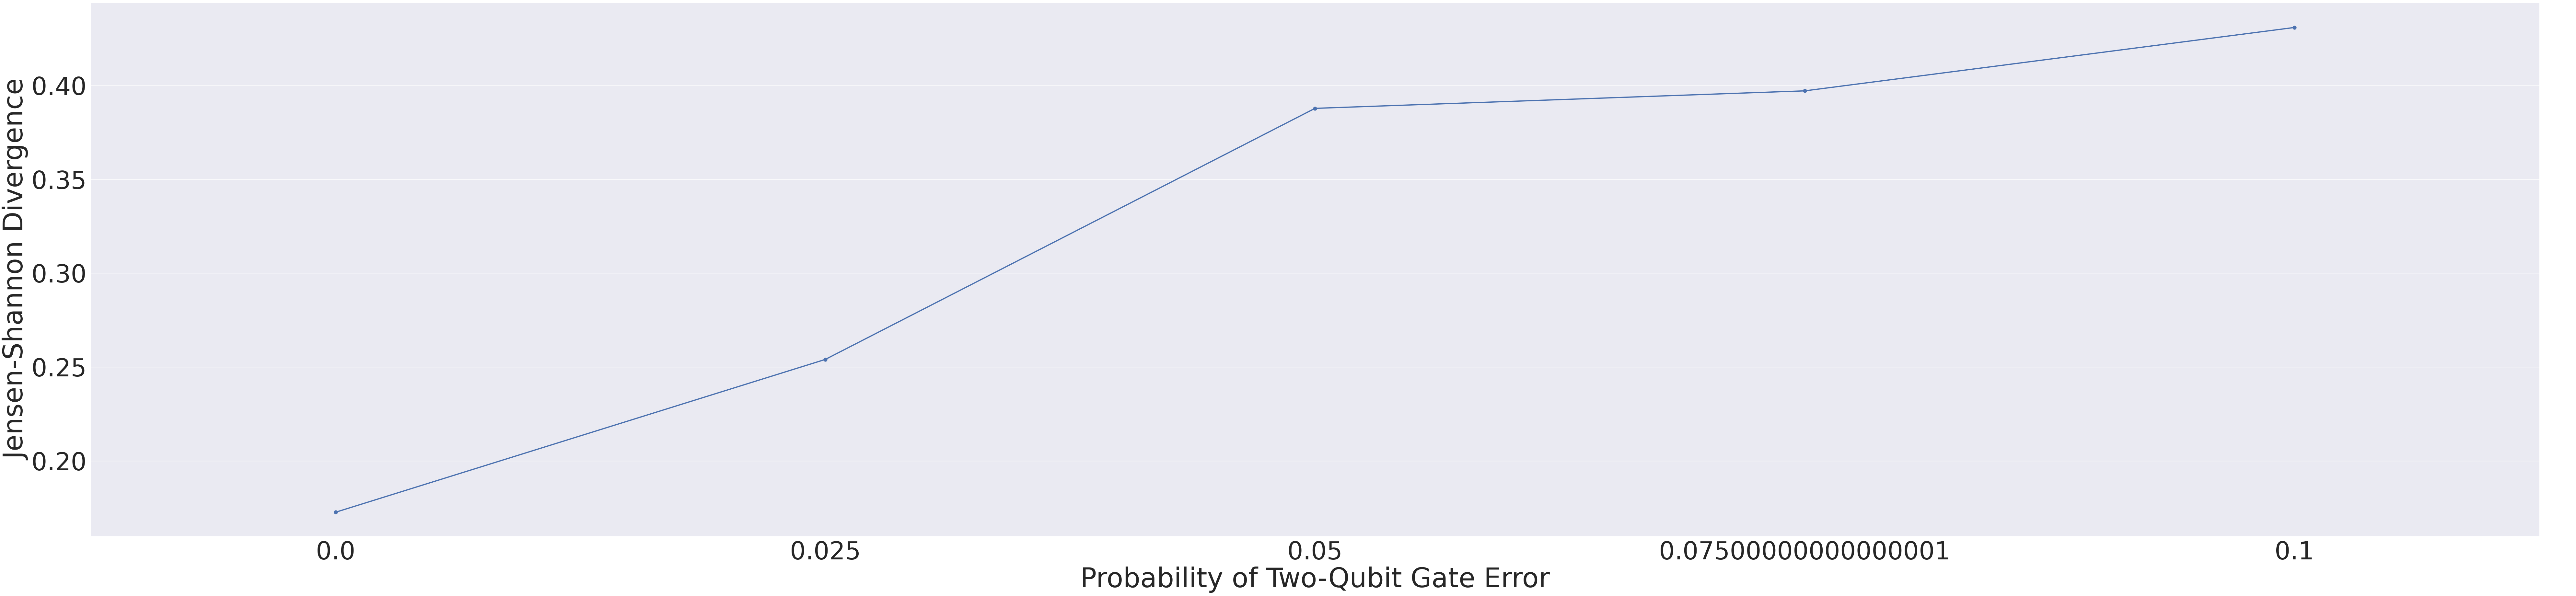

In [79]:
ax = sns.catplot(df, x="P2", y="JSD", kind="point", aspect=4, height=20)
ax.set_xlabels("Probability of Two-Qubit Gate Error")
ax.set_ylabels("Jensen-Shannon Divergence")

## Summary

H-Series provides emulators for end users to test, verify and optimize the jobs they will eventual submit to the H-Series devices. Two simulation modes exist for H-Series, `state-vector` and `stabilizer`. The simulation type will depend on the end users' use case. The noise model can be disabled, and the a local noiseless emulator is available via `pytket-pecos`. The noise model in the cloud emulator can be configured and customized by submitting options to the Quantinuum API by constructing `QuantinuumBackend` and using the keyword argument, `options`, or by using the instance method, `process_circuit` (`process_circuits`) with the keyword argument `options`.

A use case showcases how increasing the `p2` value in the cloud emulator noise model leads to worse JSD estimates.

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>